##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Core API 和 DTensor 进行分布式训练

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/core/distribution"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/distribution.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/core/distribution.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/core/distribution.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

## 简介

此笔记本使用 [TensorFlow Core 低级 API](https://tensorflow.google.cn/guide/core) 和 [DTensor](https://tensorflow.google.cn/guide/dtensor_overview) 来演示数据并行分布式训练示例。访问 [Core API 概述](https://tensorflow.google.cn/guide/core)以详细了解 TensorFlow Core 及其预期用例。请参阅 [DTensor 概述](https://tensorflow.google.cn/guide/dtensor_overview)指南和[使用 DTensor 进行分布式训练](https://tensorflow.google.cn/tutorials/distribute/dtensor_ml_tutorial)教程以详细了解 DTensor。

本示例使用[多层感知器](https://tensorflow.google.cn/guide/core/mlp_core)教程中显示的相同模型和优化器。首先请参阅本教程，以熟悉使用 Core API 编写端到端机器学习工作流。

注：DTensor 仍然是一个实验性 TensorFlow API，这意味着它的功能可用于测试，并且仅用于测试环境。

## 使用 DTensor 进行数据并行训练的概述

在构建支持分布的 MLP 之前，花点时间探索 DTensor 用于数据并行训练的基础知识。

DTensor 允许您跨设备运行分布式训练，以提高效率、可靠性和可扩缩性。DTensor 通过称为单程序多数据 (SPMD) 扩展的过程根据分片指令分布程序和张量。`DTensor` 感知层的变量被创建为 `dtensor.DVariable`，除了通常的层参数外，`DTensor` 感知层对象的构造函数还接受额外的 `Layout` 输入。

数据并行训练的主要思路如下：

- 分别在 N 台设备上复制模型变量。
- 将全局批次拆分成 N 个按副本批次。
- 每个按副本批次都在副本设备上进行训练。
- 在对所有副本共同执行数据加权之前进行梯度归约。
- 数据并行训练能够根据设备数量提供近乎线性的速度。

## 安装

DTensor 是 TensorFlow 2.9.0 版本的一部分。

In [2]:
#!pip install --quiet --upgrade --pre tensorflow

In [3]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.experimental import dtensor
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2022-12-14 22:16:35.273675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:35.273768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:16:35.273778: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2.11.0


为本实验配置 8 个虚拟 CPU。DTensor 也可以与 GPU 或 TPU 设备一起使用。鉴于此笔记本使用虚拟设备，分布式训练所获得的加速效果并不明显。 

In [5]:
def configure_virtual_cpus(ncpu):
  phy_devices = tf.config.list_physical_devices('CPU')
  tf.config.set_logical_device_configuration(phy_devices[0], [
        tf.config.LogicalDeviceConfiguration(),
    ] * ncpu)

configure_virtual_cpus(8)

DEVICES = [f'CPU:{i}' for i in range(8)]
devices = tf.config.list_logical_devices('CPU')
device_names = [d.name for d in devices]
device_names

['/device:CPU:0',
 '/device:CPU:1',
 '/device:CPU:2',
 '/device:CPU:3',
 '/device:CPU:4',
 '/device:CPU:5',
 '/device:CPU:6',
 '/device:CPU:7']

## MNIST 数据集

可从 [TensorFlow Datasets](https://tensorflow.google.cn/datasets/catalog/mnist) 获得该数据集。将数据拆分为训练集和测试集。仅使用 5000 个样本进行训练和测试以节省时间。

In [6]:
train_data, test_data = tfds.load("mnist", split=['train[:5000]', 'test[:5000]'], batch_size=128, as_supervised=True)

### 预处理数据

通过将数据的形状改变为二维并重新缩放数据以适合单位区间 [0,1] 来预处理数据。

In [7]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, test_data = train_data.map(preprocess), test_data.map(preprocess)

## 构建 MLP

使用 DTensor 感知层构建 MLP 模型。

### 密集层

首先创建一个支持 DTensor 的密集层模块。`dtensor.call_with_layout` 函数可用于调用接受 DTensor 输入并产生 DTensor 输出的函数。这对于使用 TensorFlow 支持的函数初始化 DTensor 变量 `dtensor.DVariable` 十分有用。

In [8]:
class DenseLayer(tf.Module):

  def __init__(self, in_dim, out_dim, weight_layout, activation=tf.identity):
    super().__init__()
    # Initialize dimensions and the activation function
    self.in_dim, self.out_dim = in_dim, out_dim
    self.activation = activation

    # Initialize the DTensor weights using the Xavier scheme
    uniform_initializer = tf.function(tf.random.stateless_uniform)
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(self.in_dim + self.out_dim, tf.float32))
    self.w = dtensor.DVariable(
      dtensor.call_with_layout(
          uniform_initializer, weight_layout,
          shape=(self.in_dim, self.out_dim), seed=(22, 23),
          minval=-xavier_lim, maxval=xavier_lim))
        
    # Initialize the bias with the zeros
    bias_layout = weight_layout.delete([0])
    self.b = dtensor.DVariable(
      dtensor.call_with_layout(tf.zeros, bias_layout, shape=[out_dim]))

  def __call__(self, x):
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

### MLP 序贯模型

现在，创建一个按顺序执行密集层的 MLP 模块。

In [9]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

使用 DTensor 执行“数据并行”训练等效于 `tf.distribute.MirroredStrategy`。为此，每个设备将在数据批次的一个分片上运行相同的模型。因此，您将需要以下各项：

- 具有单个 `"batch"` 维度的 `dtensor.Mesh`
- 用于在网格中复制（对每个轴使用 `dtensor.UNSHARDED`）的所有权重的 `dtensor.Layout`
- 用于在网格中拆分批次维度的数据的 `dtensor.Layout`

创建一个包含单个批次维度的 DTensor 网格，其中每个设备都成为从全局批次接收分片的副本。使用此网格实例化具有以下架构的 MLP 模式：

前向传递：ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)


In [10]:
mesh = dtensor.create_mesh([("batch", 8)], devices=DEVICES)
weight_layout = dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh)

input_size = 784
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_2_size = 10

mlp_model = MLP([
    DenseLayer(in_dim=input_size, out_dim=hidden_layer_1_size, 
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_1_size , out_dim=hidden_layer_2_size,
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_2_size, out_dim=hidden_layer_2_size, 
               weight_layout=weight_layout)])

### 训练指标

使用交叉熵损失函数和准确率指标进行训练。

In [11]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(y_pred, axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### 优化器

与标准梯度下降相比，使用优化器可以显著加快收敛速度​​。Adam 优化器在下面实现，并已配置为与 DTensor 兼容。要将 Keras 优化器与 DTensor 一起使用，请参阅实验性 `tf.keras.dtensor.experimental.optimizers` 模块。

In [12]:
class Adam(tf.Module):

    def __init__(self, model_vars, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.model_vars = model_vars
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      # Initialize optimizer variable slots
      for var in model_vars:
        v = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        s = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        self.v_dvar.append(v)
        self.s_dvar.append(s)

    def apply_gradients(self, grads):
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, self.model_vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

### 数据打包

首先，编写一个用于将数据传输到设备的辅助函数。此函数应使用 `dtensor.pack` 将用于副本的全局批次的分片发送（并且仅发送）到支持副本的设备。为简单起见，假设采用一个单客户端应用。

接下来，编写一个函数，它使用此辅助函数将训练数据批次打包到沿批次（第一个）轴分片的 DTensor 中。这可确保 DTensor 将训练数据均匀分布到“批次”网格维度。请注意，在 DTensor 中，批次大小始终指全局批次大小；因此，批次大小的选择应使其可以被批次网格维度的大小均匀拆分。计划使用其他 DTensor API 来简化 `tf.data` 集成，敬请期待。

In [13]:
def repack_local_tensor(x, layout):
  # Repacks a local Tensor-like to a DTensor with layout
  # This function assumes a single-client application
  x = tf.convert_to_tensor(x)
  sharded_dims = []

  # For every sharded dimension, use tf.split to split the along the dimension.
  # The result is a nested list of split-tensors in queue[0].
  queue = [x]
  for axis, dim in enumerate(layout.sharding_specs):
    if dim == dtensor.UNSHARDED:
      continue
    num_splits = layout.shape[axis]
    queue = tf.nest.map_structure(lambda x: tf.split(x, num_splits, axis=axis), queue)
    sharded_dims.append(dim)

  # Now we can build the list of component tensors by looking up the location in
  # the nested list of split-tensors created in queue[0].
  components = []
  for locations in layout.mesh.local_device_locations():
    t = queue[0]
    for dim in sharded_dims:
      split_index = locations[dim]  # Only valid on single-client mesh.
      t = t[split_index]
    components.append(t)

  return dtensor.pack(components, layout)

def repack_batch(x, y, mesh):
  # Pack training data batches into DTensors along the batch axis
  x = repack_local_tensor(x, layout=dtensor.Layout(['batch', dtensor.UNSHARDED], mesh))
  y = repack_local_tensor(y, layout=dtensor.Layout(['batch'], mesh))
  return x, y

### 训练

编写一个可跟踪的函数，在给定一批数据的情况下执行单个训练步骤。此函数不需要任何特殊的 DTensor 注解。此外，还要编写一个执行测试步骤并返回适当性能指标的函数。

In [14]:
@tf.function
def train_step(model, x_batch, y_batch, loss, metric, optimizer):
  # Execute a single training step
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  # Compute gradients and update the model's parameters
  grads = tape.gradient(batch_loss, model.trainable_variables)
  optimizer.apply_gradients(grads)
  # Return batch loss and accuracy
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

@tf.function
def test_step(model, x_batch, y_batch, loss, metric):
  # Execute a single testing step
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

现在，以 128 为批次大小对 MLP 模型训练 3 个周期。

In [15]:
# Initialize the training loop parameters and structures
epochs = 3
batch_size = 128
train_losses, test_losses = [], []
train_accs, test_accs = [], []
optimizer = Adam(mlp_model.trainable_variables)

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate through training data
  for x_batch, y_batch in train_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = train_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy, optimizer)
   # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate through testing data
  for x_batch, y_batch in test_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = test_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy)
    # Keep track of batch-level testing
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

# Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  print(f"Epoch: {epoch}")
  print(f"Training loss: {train_loss.numpy():.3f}, Training accuracy: {train_acc.numpy():.3f}")
  print(f"Testing loss: {test_loss.numpy():.3f}, Testing accuracy: {test_acc.numpy():.3f}")

Epoch: 0
Training loss: 1.850, Training accuracy: 0.343
Testing loss: 1.375, Testing accuracy: 0.504


Epoch: 1
Training loss: 1.028, Training accuracy: 0.674
Testing loss: 0.744, Testing accuracy: 0.782


Epoch: 2
Training loss: 0.578, Training accuracy: 0.839
Testing loss: 0.486, Testing accuracy: 0.869


### 性能评估

首先，编写一个绘图函数来呈现模型在训练期间的损失和准确率。 

In [16]:
def plot_metrics(train_metric, test_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(test_metric)), test_metric, label = f"Testing {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training Epochs");

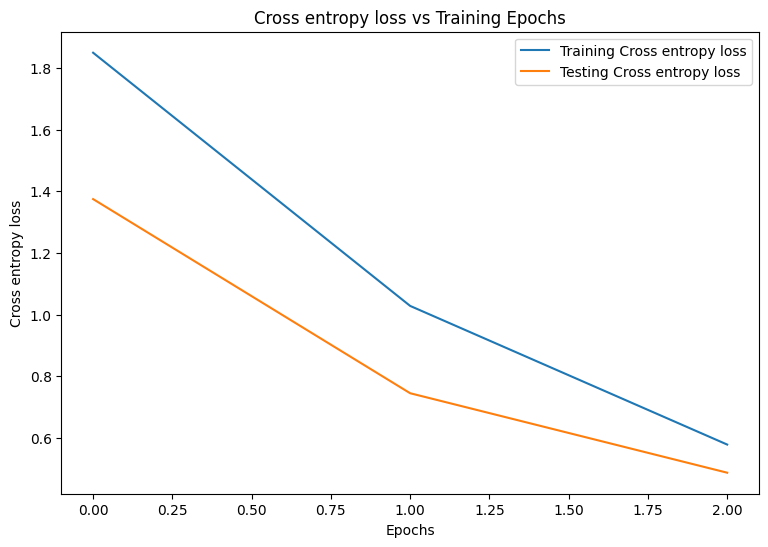

In [17]:
plot_metrics(train_losses, test_losses, "Cross entropy loss")

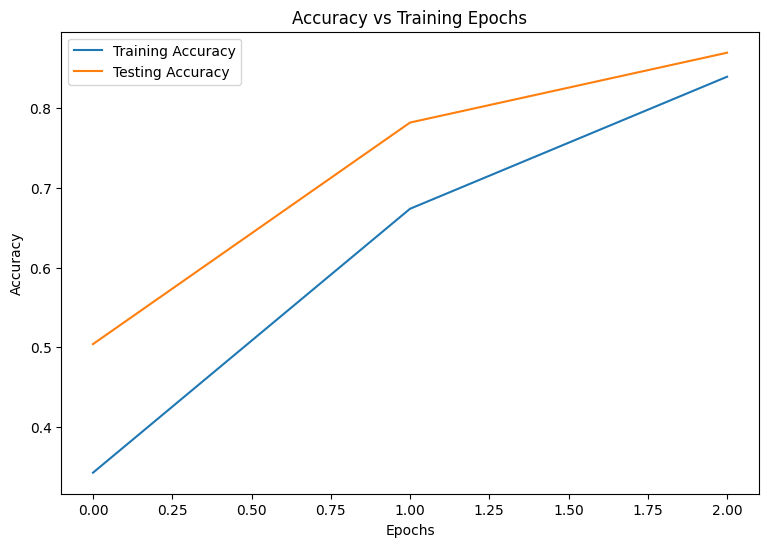

In [18]:
plot_metrics(train_accs, test_accs, "Accuracy")

## 保存模型

`tf.saved_model` 和 DTensor 的集成仍在开发中。从 TensorFlow 2.9.0 开始，tf.saved_model 仅接受具有完全复制变量的 DTensor 模型。作为替代方法，您可以通过重新加载检查点将 DTensor 模型转换为完全复制的模型。但是，保存模型后，所有 DTensor 注解都会丢失，保存的签名只能与常规张量一起使用。本教程将在固化后进行更新以展示集成。


## 结论

此笔记本概括介绍了如何使用 DTensor 和 TensorFlow Core API 进行分布式训练。下面是一些可能有所帮助的提示：

- [TensorFlow Core API](https://tensorflow.google.cn/guide/core) 可用于构建具有高度可配置性的机器学习工作流，并支持分布式训练。
- [DTensor 概念](https://tensorflow.google.cn/guide/dtensor_overview)指南和[使用 DTensor 进行分布式训练](https://tensorflow.google.cn/tutorials/distribute/dtensor_ml_tutorial)教程包含有关 DTensor 及其集成的最新信息。

有关使用 TensorFlow Core API 的更多示例，请查阅[指南](https://tensorflow.google.cn/guide/core)。如果您想详细了解如何加载和准备数据，请参阅有关[图像数据加载](https://tensorflow.google.cn/tutorials/load_data/images)或 [CSV 数据加载](https://tensorflow.google.cn/tutorials/load_data/csv)的教程。